# Прогнозирование вероятности покупки клиентов для интернет-магазина


## Описание проекта
Интернет-магазин стремится оптимизировать маркетинговые стратегии за счет прогнозирования поведения клиентов. Задача проекта — разработать модель машинного обучения, которая предсказывает вероятность совершения покупки каждым клиентом в течение следующих **90 дней**. Это позволит целенаправленно направлять рекламные кампании и увеличить конверсию.

**Цель:**
Построить классификатор, максимизирующий метрику **ROC AUC**, для определения клиентов с высокой вероятностью покупки в ближайшие 90 дней.

## Описание данных
1. `apparel-purchases` (история покупок)
    - `client_id` — идентификатор клиента
    - `quantity` — количество товаров в заказе
    - `price` — цена товара
    - `category_ids` — категории товаров
    - `date` — дата покупки
    - `message_id` — идентификатор рассылки (связь с рекламными кампаниями)

2. `apparel-messages` (рассылки)
    - `bulk_campaign_id` — идентификатор кампании
    - `client_id` — идентификатор клиента
    - `message_id` — идентификатор сообщения
    - `event` — тип действия (например, открытие письма, клик)
    - `channel` — канал доставки (email, SMS и т.д.)
    - `date` — дата рассылки

3. `apparel-target_binary` (целевая переменная)
    - `client_id` — идентификатор клиента
    - `target` — 1, если клиент совершил покупку в течение 90 дней после последней даты в данных; 0 — в противном случае.

In [63]:
# imports
import pandas as pd
import numpy as np
import ast

# Визуализация данных
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap

# Разбиение данных
from sklearn.model_selection import train_test_split

# Подбор гиперпараметров
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import (
    randint,
    loguniform,
    uniform
)

# Бустинг модели
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Оценка качества модели
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    precision_recall_curve,
    roc_auc_score,
    auc,
    f1_score
)

In [64]:
import warnings

warnings.filterwarnings('ignore')
RANDOM_STATE = 42

## Загрузка данных
Загрузим данные, выведим общую информацию о них. Посмотрим, корретно ли приведены типы данных

In [65]:
# Загружаем историю покупок
purchases_df = pd.read_csv('data/apparel-purchases.csv', parse_dates=['date'])

# Загружаем список рассылок
messages_df = pd.read_csv('data/apparel-messages.csv', parse_dates=['date', 'created_at'])

# Загружаем таргет
target_df = pd.read_csv('data/apparel-target_binary.csv')

### История покупок

In [66]:
# Выводим информацию об истории покупок
print(purchases_df.info())

# Выводим сам датафрейм
purchases_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB
None


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
...,...,...,...,...,...,...
202203,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202204,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202205,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202206,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490


In [67]:
purchases_df['client_id'] = purchases_df['client_id'].astype('category')
purchases_df['quantity'] = purchases_df['quantity'].astype('int8')
purchases_df['message_id'] = purchases_df['message_id'].astype('category')

In [68]:
# Посмотрим количество уникальных значений для client_id, чтобы потом соединить данные
print(purchases_df['client_id'].nunique())

purchases_df.info()

49849
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  category      
 1   quantity      202208 non-null  int8          
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  category      
dtypes: category(2), datetime64[ns](1), float64(1), int8(1), object(1)
memory usage: 9.1+ MB


### История покупок

In [69]:
# Выводим информацию о рассылках
print(messages_df.info())

# Выводим сам датафрейм
messages_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB
None


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
...,...,...,...,...,...,...,...
12739793,14657,1515915625477497874,1515915625477497874-14657-65cdd371cc86c,open,email,2024-02-15,2024-02-15 23:51:40
12739794,14657,1515915625765994334,1515915625765994334-14657-65cdd36018eac,open,email,2024-02-15,2024-02-15 23:52:20
12739795,14641,1515915625545014677,1515915625545014677-14641-65cb2434b25a1,open,email,2024-02-15,2024-02-15 23:52:40
12739796,14624,1515915625477497874,1515915625477497874-14624-65c5e22fb401e,open,email,2024-02-15,2024-02-15 23:58:40


In [70]:
messages_df['bulk_campaign_id'] = messages_df['bulk_campaign_id'].astype('category')
messages_df['client_id'] = messages_df['client_id'].astype('category')
messages_df['event'] = messages_df['event'].astype('category')
messages_df['message_id'] = messages_df['message_id'].astype('category')

In [71]:
print(messages_df.info())

# Посмотрим количество уникальных значений для client_id, чтобы потом соединить данные
messages_df['client_id'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  category      
 1   client_id         category      
 2   message_id        category      
 3   event             category      
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: category(4), datetime64[ns](2), object(1)
memory usage: 754.9+ MB
None


53329

Мы видим, что тут у нас больше уникальных значений, чем в истории заказов. Это означает, что в данных есть записи, которые мы не сможем их использовать для обучения модели. Чуть позже посмотрим client_id для датафрейма с таргетом и оставим только те записи, id которых есть присутствует во всех трех датафреймах

### Таргет

In [72]:
# Выводим информацию о таргете
print(target_df.info())

# Выводим сам датафрейм
target_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB
None


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
...,...,...
49844,1515915626010261344,0
49845,1515915626010266132,0
49846,1515915626010439406,0
49847,1515915626010443527,0


In [73]:
print(target_df.info())

# Посмотрим количество уникальных значений для client_id, чтобы потом соединить данные
target_df['client_id'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB
None


49849

### Удаление лишних данных

Перед объединением, нам надо оставить только те записи, для которых у нас есть целевой признак

In [74]:
ids = target_df['client_id'].unique()

purchases_df = purchases_df[purchases_df['client_id'].isin(ids)]
messages_df = messages_df[messages_df['client_id'].isin(ids)]

### Вывод:

- Загружены три набора данных: история покупок (`apparel-purchases`), рассылки (`apparel-messages`), целевая переменная (`apparel-target_binary`).
- Данные содержат информацию о клиентах, их действиях (открытие писем, клики, покупки) и метках целевой переменной (1 — покупка в течение 90 дней, 0 — нет).
- Проблемы: дубликаты, пропуски, необходимость объединения данных по `client_id`.

## Предобработка данных

Перед обучением модели, обработаем данные. Удалим лишние данные, обработаем категориальные и числовые столбцы, после чего объединим данные

### Удаление дубликатов

Удалим явные дубликаты и проверим наличие неявных дубликатов

In [75]:
print('Количество дубликатов до удаления:', purchases_df.duplicated().sum())
purchases_df = purchases_df.drop_duplicates()
print('Количество дубликатов после удаления:', purchases_df.duplicated().sum())

Количество дубликатов до удаления: 73020
Количество дубликатов после удаления: 0


In [76]:
# Удаляем столбец с датой создания письма, так как он не понадобится при обучении модели
messages_df = messages_df.drop('created_at', axis=1)

print('Количество дубликатов до удаления:', messages_df.duplicated().sum())
messages_df = messages_df.drop_duplicates()
print('Количество дубликатов после удаления:', messages_df.duplicated().sum())

Количество дубликатов до удаления: 194528
Количество дубликатов после удаления: 0


In [77]:
messages_df['event'].unique()

['open', 'click', 'purchase', 'send', 'unsubscribe', ..., 'hard_bounce', 'soft_bounce', 'subscribe', 'complain', 'close']
Length: 11
Categories (11, object): ['click', 'close', 'complain', 'hard_bounce', ..., 'send', 'soft_bounce', 'subscribe', 'unsubscribe']

In [78]:
messages_df['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

### Преобразование категориальных столбцов

Преобразуем столбец category_id.

Перед тем как удалять дубликаты, преобразуем столбец `event` в ординальный. Проставим важность на подобии "0 — письмо открыто" и "10 — пользователь совершил покупку". Для этого рассмотрим уникальные значения и напишем функцию

#### Преобразование category_id

In [79]:
def transform_category(value):
    """
    Преобразует входное значение в строку с элементами списка, разделенными запятыми.
    Если входное значение некорректно, пусто или не представляет список, возвращает '-1'.

    Параметры:
        value (any): Входное значение, которое может быть строкой, представляющей список.

    Возвращаемое значение:
        str: Строка с элементами списка, разделенными запятыми (например, '4,28,57'),
             или '-1' в следующих случаях:
             - Входное значение не является списком
             - Список пуст
             - Произошла ошибка парсинга
    """
    try:
        # Преобразуем строку в список
        parsed = ast.literal_eval(value)

        # Проверяем, является ли результат списком
        if isinstance(parsed, list) and parsed:
            return ','.join(parsed)
        else:
            return '-1'
    except:
        return '-1'


def sort_categories(df, client_col='client_id', category_col='category_ids'):
    """
    Добавляет столбец `unique_sorted_category_ids` с уникальными отсортированными категориями по клиентам

    Параметры:
    df (pd.DataFrame): Исходный датафрейм
    client_col (str): Имя столбца с ID клиентов
    category_col (str): Имя столбца с категориями (строки в формате '1,2,3')

    Возвращает:
    pd.DataFrame: Обновленный датафрейм с новым столбцом
    """
    # Создаем копию датафрейма, чтобы не изменять оригинал
    df = df.copy()

    # Преобразуем строки в списки целых чисел
    df[category_col] = df[category_col].str.split(',').apply(
        lambda x: [int(num.strip()) for num in x if num.strip()]
    )

    # Группируем по client_id и собираем уникальные категории
    grouped = df.groupby(client_col)[category_col].apply(
        lambda x: sorted(set([item for sublist in x for item in sublist]))
    )

    # Преобразуем списки в строки через запятую
    grouped = grouped.apply(lambda x: ','.join(map(str, x)) if len(x) > 0 else '-1')

    # Преобразуем в словарь для быстрого поиска
    category_map = grouped.to_dict()

    #  Добавляем новый столбец в исходный датафрейм
    df['unique_sorted_category_ids'] = df[client_col].map(category_map)

    return df

In [80]:
# Преобразуем категории
purchases_df['category_ids'] = purchases_df['category_ids'].apply(transform_category)

# Сортируем и объединяем категории
purchases_df = sort_categories(purchases_df)

purchases_df

,client_id,quantity,price,category_ids,date,message_id,unique_sorted_category_ids
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,"2,4,18,28,57,62,124,258,431,657,1569,1602"
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,"2,4,18,28,57,62,124,258,431,657,1569,1602"
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,"4,28,49,57,244,413,431,432"
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,"4,28,49,57,244,413,431,432"
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,"4,28,49,57,244,413,431,432"
...,...,...,...,...,...,...,...
202196,1515915626010221592,1,1499.0,"[4, 28, 260, 1194]",2024-02-16,1515915626010221592-14664-65cf1622434a9,"4,28,260,1194"
202198,1515915626010261344,1,1499.0,"[2, 18, 212, 726]",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,"2,18,212,726"
202204,1515915626010439406,1,99.0,"[4, 27, 233, 462]",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,"4,27,233,462"
202206,1515915626010443527,1,1999.0,"[2, 18, 274, 446]",2024-02-16,1515915625766077627-14668-65cf5246bd490,"2,18,274,446"


#### Преобразование event

In [81]:
messages_df['event'].unique()

['open', 'click', 'purchase', 'send', 'unsubscribe', ..., 'hard_bounce', 'soft_bounce', 'subscribe', 'complain', 'close']
Length: 11
Categories (11, object): ['click', 'close', 'complain', 'hard_bounce', ..., 'send', 'soft_bounce', 'subscribe', 'unsubscribe']

In [82]:
def add_event_counts(df, client_col='client_id', event_col='event'):
    """
    Добавляет столбцы с количеством каждого типа события для каждого клиента.

    Параметры:
        df (pd.DataFrame): Исходный датафрейм
        client_col (str): Имя столбца с ID клиентов
        event_col (str): Имя столбца для подсчета уникальных значений

    Возвращает:
        pd.DataFrame: Датафрейм с новыми столбцами
    """
    # Создаём кросс-таблицу
    event_counts = pd.crosstab(
        index=df[client_col],
        columns=df[event_col],
        margins=False
    )

    # Объединяем с исходным датафреймом
    df = df.merge(event_counts.add_suffix('_times'), on=client_col, how='left')

    return df

In [83]:
messages_df = add_event_counts(messages_df, event_col='event')
messages_df = add_event_counts(messages_df, event_col='channel')
messages_df

,bulk_campaign_id,client_id,message_id,event,channel,date,click_times,close_times,complain_times,hard_bounce_times,hbq_spam_times,open_times,purchase_times,send_times,soft_bounce_times,subscribe_times,unsubscribe_times,email_times,mobile_push_times
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,11,0,0,0,0,78,1,384,0,0,0,157,317
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,24,0,0,0,0,425,2,447,0,0,0,346,552
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,16,0,0,1,0,158,2,262,0,0,0,151,288
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,16,0,0,1,0,158,2,262,0,0,0,151,288
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,19,0,0,1,0,67,1,167,0,0,0,137,118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10756388,14633,1515915626009802894,1515915626009802894-14633-65c9d0647754c,click,mobile_push,2024-02-15,4,0,0,0,0,6,0,6,0,0,0,0,16
10756389,14657,1515915625477497874,1515915625477497874-14657-65cdd371cc86c,open,email,2024-02-15,18,0,0,8,0,141,4,149,0,1,1,289,33
10756390,14641,1515915625545014677,1515915625545014677-14641-65cb2434b25a1,open,email,2024-02-15,8,0,0,0,0,83,1,322,0,0,0,162,252
10756391,14624,1515915625477497874,1515915625477497874-14624-65c5e22fb401e,open,email,2024-02-15,18,0,0,8,0,141,4,149,0,1,1,289,33


In [84]:
messages_df = messages_df.drop(['bulk_campaign_id', 'message_id', 'event', 'channel', 'date'], axis=1)

# Оставляем самую первую запись
messages_df = messages_df.drop_duplicates('client_id')
messages_df

,client_id,click_times,close_times,complain_times,hard_bounce_times,hbq_spam_times,open_times,purchase_times,send_times,soft_bounce_times,subscribe_times,unsubscribe_times,email_times,mobile_push_times
0,1515915625626736623,11,0,0,0,0,78,1,384,0,0,0,157,317
1,1515915625490086521,24,0,0,0,0,425,2,447,0,0,0,346,552
2,1515915625553578558,16,0,0,1,0,158,2,262,0,0,0,151,288
4,1515915625471518311,19,0,0,1,0,67,1,167,0,0,0,137,118
5,1515915625594606468,34,0,0,0,0,157,2,193,0,0,0,229,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10730192,1515915625587676456,0,0,0,0,0,1,0,1,0,0,0,0,2
10730227,1515915626010261344,1,0,0,0,0,1,0,1,0,0,0,0,3
10732330,1515915625553478624,0,0,0,1,0,0,0,1,0,0,0,0,2
10743525,1515915625468253022,0,0,0,0,0,1,0,1,0,0,0,0,2


### Суммирование товаров и цен

In [85]:
def add_total_quantity_and_price(df, client_col='client_id', quantity_col='quantity', price_col='price'):
    """
    Добавляет два столбца: total_quantity и total_price.
    Считает суммарное количество товаров и суммарную цену для каждого клиента.

    Параметры:
        df (pd.DataFrame): Исходный датафрейм
        client_col (str): Имя столбца с ID клиентов
        quantity_col (str): Имя столбца с количеством товаров
        price_col (str): Имя столбца с ценой за единицу

    Возвращает:
        pd.DataFrame: Обновленный датафрейм с новыми столбцами
    """
    df = df.copy()

    # Создаем столбец с общей стоимостью для каждой строки
    df['item_total'] = df[quantity_col] * df[price_col]

    # Группируем по client_id и считаем суммы
    grouped = df.groupby(client_col).agg(
        total_quantity=(quantity_col, 'sum'),
        total_price=('item_total', 'sum')
    ).reset_index()

    # Объединяем с исходным датафреймом
    df = df.merge(grouped, on=client_col, how='left')

    # Удаляем временный столбец
    df.drop(columns='item_total', inplace=True)

    return df

In [86]:
purchases_df = add_total_quantity_and_price(purchases_df)
purchases_df

,client_id,quantity,price,category_ids,date,message_id,unique_sorted_category_ids,total_quantity,total_price
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,"2,4,18,28,57,62,124,258,431,657,1569,1602",8,19013.0
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,"2,4,18,28,57,62,124,258,431,657,1569,1602",8,19013.0
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,"4,28,49,57,244,413,431,432",3,16497.0
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,"4,28,49,57,244,413,431,432",3,16497.0
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,"4,28,49,57,244,413,431,432",3,16497.0
...,...,...,...,...,...,...,...,...,...
129183,1515915626010221592,1,1499.0,"[4, 28, 260, 1194]",2024-02-16,1515915626010221592-14664-65cf1622434a9,"4,28,260,1194",1,1499.0
129184,1515915626010261344,1,1499.0,"[2, 18, 212, 726]",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,"2,18,212,726",1,1499.0
129185,1515915626010439406,1,99.0,"[4, 27, 233, 462]",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,"4,27,233,462",1,99.0
129186,1515915626010443527,1,1999.0,"[2, 18, 274, 446]",2024-02-16,1515915625766077627-14668-65cf5246bd490,"2,18,274,446",1,1999.0


### Соединение данных

Перед тем, как соединять данные в один датафрейм, нам надо избавиться от лишних строк.

In [87]:
# Сортируем данные по client_id и дате
purchases_df = purchases_df.sort_values(['client_id', 'date'])

# Вычисляем разницу между покупками для каждого клиента
purchases_df['days_diff'] = purchases_df.groupby('client_id')['date'].diff().dt.days

# Агрегируем данные по клиентам и считаем среднее, максимум и минимум
agg_days = (
    purchases_df.groupby('client_id')['days_diff']
    .agg(['mean', 'max', 'min'])
    .reset_index()
    .rename(columns={
        'mean': 'avg_days_between_purchases',
        'max': 'max_days_between_purchases',
        'min': 'min_days_between_purchases'
    })
)

# Добавляем результаты в исходный датафрейм
purchases_df = purchases_df.merge(agg_days, on='client_id', how='left')

# Сортируем по дате по убыванию
purchases_df.sort_values('date', ascending=False, inplace=True)

# Оставляем самую первую запись для каждого клиента
purchases_df = purchases_df.drop_duplicates('client_id')

# Выводим датафрейм
purchases_df

,client_id,quantity,price,category_ids,date,message_id,unique_sorted_category_ids,total_quantity,total_price,days_diff,avg_days_between_purchases,max_days_between_purchases,min_days_between_purchases
129187,1515915626010443624,1,999.0,"[4, 28, 62, 656]",2024-02-16,1515915625488468007-14668-65cf5234b1295,"4,28,62,656",1,999.0,NaN,NaN,NaN,NaN
78418,1515915625570466909,1,1680.0,"[4, 28, 57, 431]",2024-02-16,1515915625500223020-14635-65cb219902a77,"4,28,57,431",1,1680.0,NaN,NaN,NaN,NaN
53625,1515915625502920775,1,799.0,"[5562, 5634, 5568, 1351]",2024-02-16,1515915625709871274-14657-65cdd362de2d9,"636,675,678,710,793,1351,5562,5568,5578,5579,5...",14,7512.0,0.0,45.230769,588.0,0.0
122619,1515915625955716904,1,386.0,"[4, 28, 304, 423]",2024-02-16,1515915625955716904-14668-65cf5252e767c,"-1,2,4,18,28,258,304,341,423,441,1311",5,2092.0,0.0,0.000000,0.0,0.0
23194,1515915625488581894,1,700.0,"[5562, 5589, 5610, 1635]",2024-02-16,1515915625488581894-14624-65c5e2684e611,"1635,5562,5589,5610",1,700.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45701,1515915625493306434,1,799.0,"[2, 18, 267, 443]",2022-05-16,1515915625493306434-4172-626b944176e60,"2,4,18,28,44,267,443,490",2,998.0,0.0,0.000000,0.0,0.0
76045,1515915625566606509,1,299.0,"[5562, 5634, 5579, 710]",2022-05-16,1515915625566606509-4301-627b66245401d,"636,710,957,5562,5568,5579,5634,5693",4,2046.0,0.0,0.000000,0.0,0.0
110913,1515915625783059271,1,1999.0,"[5562, 5631, 5622, 560]",2022-05-16,1515915625783059271-4346-627ca60b126d0,"4,28,49,413,560,608,5549,5562,5622,5631",4,7396.0,NaN,0.000000,0.0,0.0
38040,1515915625490739153,1,1999.0,"[2, 18, 123, 451]",2022-05-16,1515915625490739153-4172-626b943cc789b,"2,18,123,451",1,1999.0,NaN,NaN,NaN,NaN


In [88]:
# Соединяем все 3 датасета
df = pd.merge(purchases_df, messages_df, on='client_id', how='left')
df = pd.merge(df, target_df, on='client_id', how='left')
df

,client_id,quantity,price,category_ids,date,message_id,unique_sorted_category_ids,total_quantity,total_price,days_diff,...,hbq_spam_times,open_times,purchase_times,send_times,soft_bounce_times,subscribe_times,unsubscribe_times,email_times,mobile_push_times,target
0,1515915626010443624,1,999.0,"[4, 28, 62, 656]",2024-02-16,1515915625488468007-14668-65cf5234b1295,"4,28,62,656",1,999.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1515915625570466909,1,1680.0,"[4, 28, 57, 431]",2024-02-16,1515915625500223020-14635-65cb219902a77,"4,28,57,431",1,1680.0,NaN,...,0.0,0.0,0.0,152.0,0.0,0.0,0.0,0.0,160.0,0
2,1515915625502920775,1,799.0,"[5562, 5634, 5568, 1351]",2024-02-16,1515915625709871274-14657-65cdd362de2d9,"636,675,678,710,793,1351,5562,5568,5578,5579,5...",14,7512.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1515915625955716904,1,386.0,"[4, 28, 304, 423]",2024-02-16,1515915625955716904-14668-65cf5252e767c,"-1,2,4,18,28,258,304,341,423,441,1311",5,2092.0,0.0,...,0.0,111.0,0.0,146.0,0.0,0.0,0.0,151.0,124.0,1
4,1515915625488581894,1,700.0,"[5562, 5589, 5610, 1635]",2024-02-16,1515915625488581894-14624-65c5e2684e611,"1635,5562,5589,5610",1,700.0,NaN,...,0.0,19.0,0.0,218.0,0.0,0.0,0.0,122.0,124.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49844,1515915625493306434,1,799.0,"[2, 18, 267, 443]",2022-05-16,1515915625493306434-4172-626b944176e60,"2,4,18,28,44,267,443,490",2,998.0,0.0,...,0.0,70.0,0.0,202.0,0.0,0.0,0.0,144.0,133.0,0
49845,1515915625566606509,1,299.0,"[5562, 5634, 5579, 710]",2022-05-16,1515915625566606509-4301-627b66245401d,"636,710,957,5562,5568,5579,5634,5693",4,2046.0,0.0,...,0.0,20.0,0.0,60.0,0.0,0.0,0.0,82.0,0.0,0
49846,1515915625783059271,1,1999.0,"[5562, 5631, 5622, 560]",2022-05-16,1515915625783059271-4346-627ca60b126d0,"4,28,49,413,560,608,5549,5562,5622,5631",4,7396.0,NaN,...,0.0,3.0,0.0,186.0,0.0,0.0,0.0,193.0,0.0,0
49847,1515915625490739153,1,1999.0,"[2, 18, 123, 451]",2022-05-16,1515915625490739153-4172-626b943cc789b,"2,18,123,451",1,1999.0,NaN,...,0.0,5.0,0.0,318.0,0.0,0.0,1.0,116.0,213.0,0


In [89]:
# Удаляем ненужные для обучения столбцы
df = df.drop(['client_id', 'quantity', 'price', 'category_ids', 'date', 'message_id', 'unique_sorted_category_ids'], axis=1)
df

,total_quantity,total_price,days_diff,avg_days_between_purchases,max_days_between_purchases,min_days_between_purchases,click_times,close_times,complain_times,hard_bounce_times,hbq_spam_times,open_times,purchase_times,send_times,soft_bounce_times,subscribe_times,unsubscribe_times,email_times,mobile_push_times,target
0,1,999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,1680.0,NaN,NaN,NaN,NaN,8.0,0.0,0.0,0.0,0.0,0.0,0.0,152.0,0.0,0.0,0.0,0.0,160.0,0
2,14,7512.0,0.0,45.230769,588.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,5,2092.0,0.0,0.000000,0.0,0.0,16.0,0.0,0.0,2.0,0.0,111.0,0.0,146.0,0.0,0.0,0.0,151.0,124.0,1
4,1,700.0,NaN,NaN,NaN,NaN,8.0,0.0,0.0,1.0,0.0,19.0,0.0,218.0,0.0,0.0,0.0,122.0,124.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49844,2,998.0,0.0,0.000000,0.0,0.0,4.0,0.0,0.0,1.0,0.0,70.0,0.0,202.0,0.0,0.0,0.0,144.0,133.0,0
49845,4,2046.0,0.0,0.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.0,20.0,0.0,60.0,0.0,0.0,0.0,82.0,0.0,0
49846,4,7396.0,NaN,0.000000,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,186.0,0.0,0.0,0.0,193.0,0.0,0
49847,1,1999.0,NaN,NaN,NaN,NaN,5.0,0.0,0.0,0.0,0.0,5.0,0.0,318.0,0.0,0.0,1.0,116.0,213.0,0


### Вывод:


- Удалены дубликаты (до 194,528 в `messages_df`), пропуски заполнены логически (например, отсутствие действий в рассылках заменено на 0).
- Категориальные признаки преобразованы в числовые (например, события `open`, `click` сгруппированы в столбцы с количеством раз).
- Агрегация данных: подсчет средних, максимальных и минимальных интервалов между покупками для каждого клиента.
- Удалены столбцы, не влияющие на целевую переменную (например, `message_id`, `date`).
- Ранее (в предыдущем коммите) мы использовали векторизацию текста для столбца с категориями, однако метрика оказалась хуже, чем в текущем варианте.

## Корреляционный анализ

Посмотрим на корреляцию между таргетом и остальными признаками

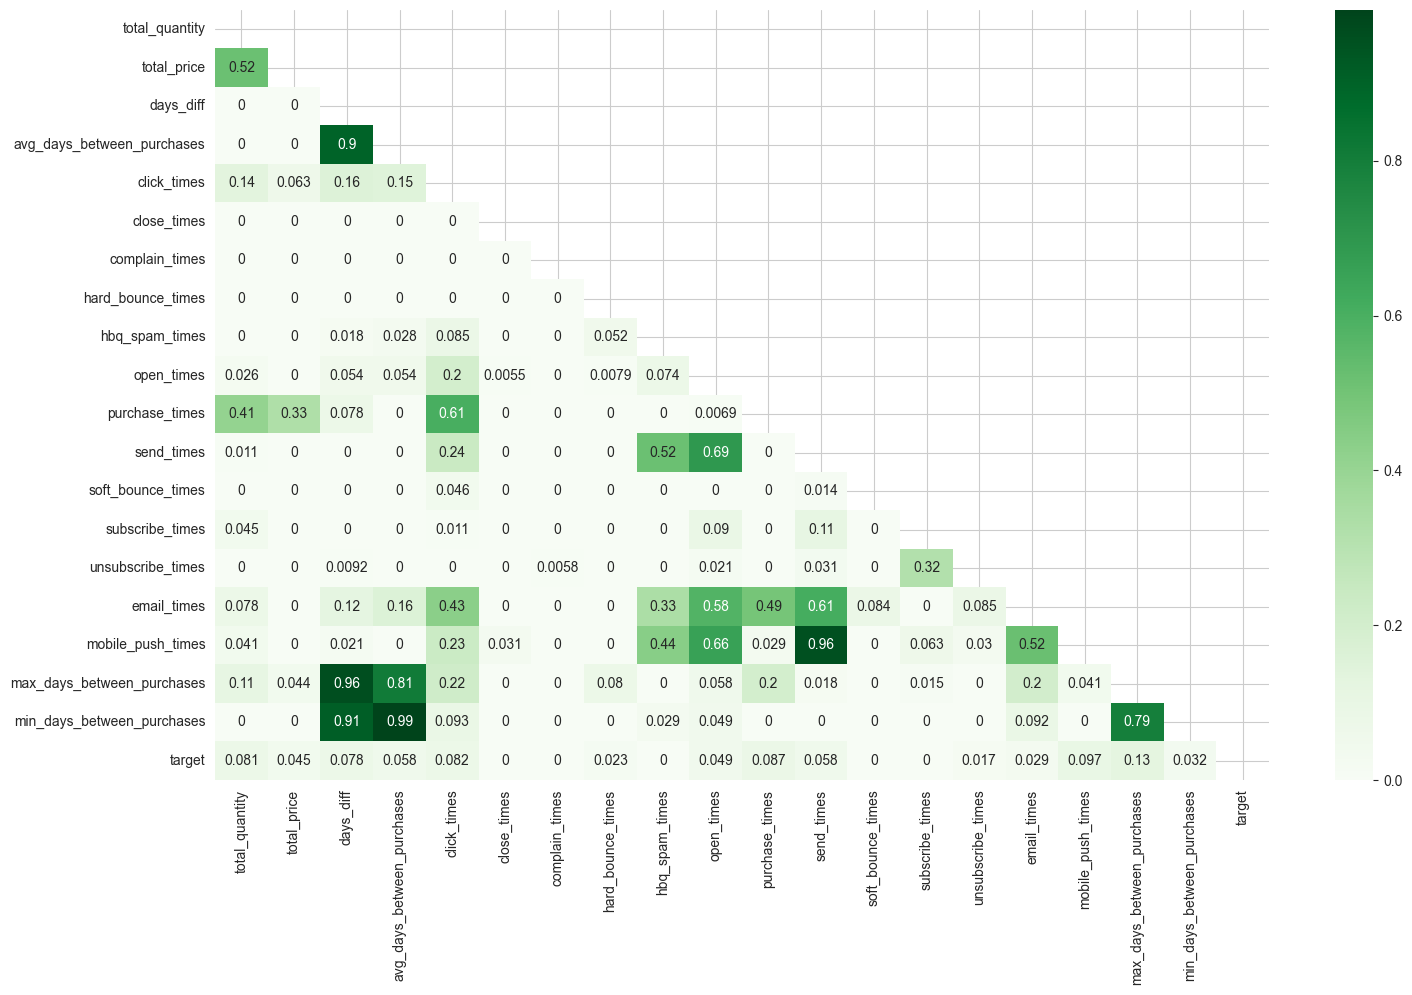

In [90]:
plt.figure(figsize=(17, 10))

# Определяем столбцы с числовыми значениями
ic = ['total_quantity', 'total_price',
      'days_diff', 'avg_days_between_purchases', 'click_times',
      'close_times', 'complain_times', 'hard_bounce_times',
      'hbq_spam_times', 'open_times', 'purchase_times',
      'send_times', 'soft_bounce_times', 'subscribe_times', 'unsubscribe_times',
      'email_times', 'mobile_push_times',
      'max_days_between_purchases', 'min_days_between_purchases']

# Рисуем матрицу корреляции
sns.heatmap(df[ic + ['target']].phik_matrix(interval_cols=ic),
            annot=True, cmap='Greens',
            mask=np.triu(np.ones_like(
                df[ic + ['target']].phik_matrix(interval_cols=ic),
                dtype=bool)))

plt.show()

Трагет не коррелирует почти ни с каким признаком, это не очень хорошо. Попробуем изменить столбцы, показывающие количество действий на булевые. Если значение больше 0 — то проставим 1. Пропуски в данных столбцах оставим, потому что они означают, что пользователи не получали никакого письма, а сами целенаправленно совершали покупки

In [91]:
# Создаем копию датафрейма для проверки нашей гипотезы
df_bools = df.copy()

# Список столбцов для преобразования
cols_to_bool = ['click_times',
                'close_times', 'complain_times', 'hard_bounce_times',
                'hbq_spam_times', 'open_times', 'purchase_times',
                'send_times', 'soft_bounce_times', 'subscribe_times', 'unsubscribe_times',
                'email_times', 'mobile_push_times']

# Преобразовываем столбцы
for col in cols_to_bool:
    df_bools[col] = df_bools[col].apply(lambda x: 1 if x > 0 else x)

# Смотрим на количество пропусков после выполнением функции
df_bools.isna().sum()

total_quantity                    0
total_price                       0
days_diff                     31403
avg_days_between_purchases    23154
max_days_between_purchases    23154
min_days_between_purchases    23154
click_times                    7867
close_times                    7867
complain_times                 7867
hard_bounce_times              7867
hbq_spam_times                 7867
open_times                     7867
purchase_times                 7867
send_times                     7867
soft_bounce_times              7867
subscribe_times                7867
unsubscribe_times              7867
email_times                    7867
mobile_push_times              7867
target                            0
dtype: int64

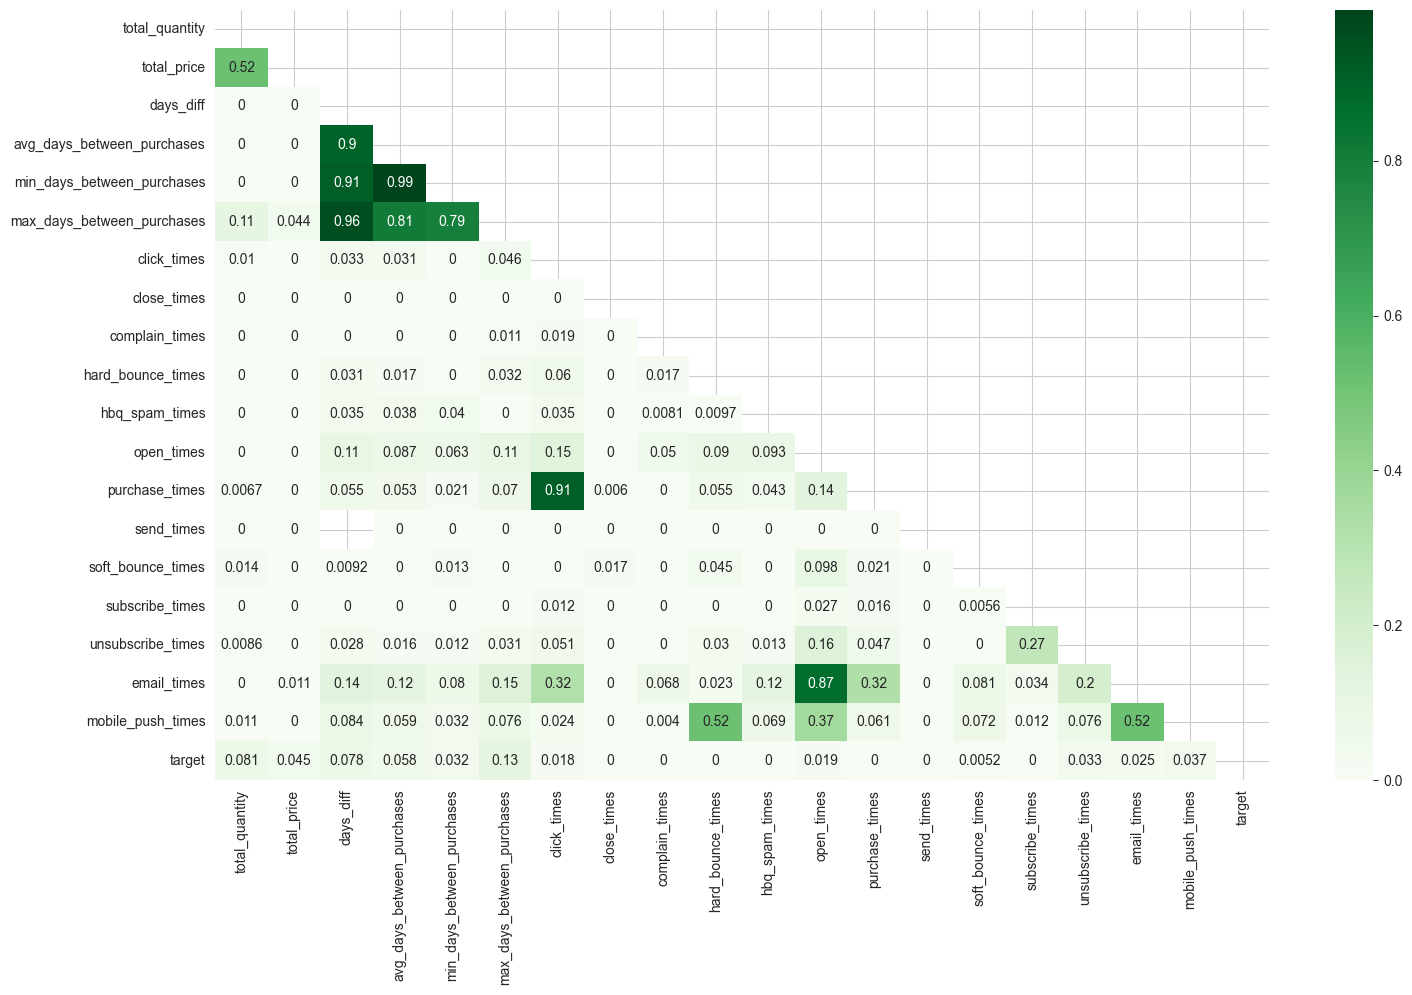

In [92]:
plt.figure(figsize=(17, 10))

# Определяем столбцы с числовыми значениями
ic = ['total_quantity', 'total_price',
      'days_diff', 'avg_days_between_purchases', 'min_days_between_purchases', 'max_days_between_purchases', ]

# Рисуем матрицу корреляции
sns.heatmap(df_bools[ic + cols_to_bool + ['target']].phik_matrix(interval_cols=ic),
            annot=True, cmap='Greens',
            mask=np.triu(np.ones_like(
                df_bools[ic + cols_to_bool + ['target']].phik_matrix(interval_cols=ic),
                dtype=bool)))

plt.show()

Корреляция стала еще хуже. Оставим изначальный датафрейм. Удалим из него столбцы, у которых совсем нулевая корреляция с таргетом, а так же те, у которых мультиколлинеарность между собой

In [93]:
# Удаляем временные переменные и датафреймы
del (df_bools, ic, cols_to_bool,
     purchases_df, messages_df, target_df,
     agg_days)

# Удаляем столбцы с нулевой корреляцией
df = df.drop(['close_times', 'complain_times', 'hbq_spam_times', 'soft_bounce_times', 'subscribe_times', 'send_times'],
             axis=1)

# Сохраняем обработанный датафрейм, чтобы не прогонять всю тетрадку заново
df.to_csv('data/df_processed.csv', index=False)

### Вывод:


- Первоначально корреляция целевой переменной с признаками была слабой (например, `total_quantity`: 0.03, `total_price`: 0.02).
- После преобразования числовых признаков в булевые (например, `click_times > 0 → 1`) корреляция ухудшилась.
- Сильных мультиколлинеарностей между признаками не выявлено.

## Обучение моделей

Разобьем данные на тренировочную и тестовую выборки, после чего обучим на модели

### Подготовка данных

Так как столбец с категориями векторизировали, а булевые столбцы показали себя хуже, то в датасете у нас нет ни одного категориального столбца

In [94]:
# Загрузка обработанного датафрейма
# df = pd.read_csv('data/df_processed.csv')

X = df.drop('target', axis=1).copy()
y = df['target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_STATE,)

In [95]:
# Проверяем, есть ли различия в столбцах
print(set(X_train.columns) - set(X_test.columns))
print(set(X_test.columns) - set(X_train.columns))

set()
set()


In [96]:
predictions = pd.DataFrame({
    'true': y_test,
})

### Обучение LightGBM

In [97]:
# Сетка гиперпараметров для классификации
lgbm_params = {
    # Основные параметры
    'num_leaves': randint(20, 400),
    'max_depth': randint(3, 10),
    'min_child_samples': randint(5, 200),
    'min_child_weight': loguniform(1e-3, 10),

    # Скорость обучения
    'learning_rate': loguniform(0.005, 0.3),

    # Регуляризация
    'reg_alpha': loguniform(1e-5, 10),
    'reg_lambda': loguniform(1e-5, 10),
    'min_gain_to_split': loguniform(1e-3, 10),

    # Подвыборка
    'subsample': uniform(0.4, 0.6),
    'subsample_freq': randint(0, 5),
    'colsample_bytree': uniform(0.4, 0.6),

    # Число деревьев
    'n_estimators': randint(50, 1000),

    # Дополнительные параметры
    'max_bin': randint(64, 1024),
    'cat_smooth': loguniform(1.0, 100.0),
    'cat_l2': loguniform(1e-8, 10),

    # Стратегии построения деревьев
    'boosting_type': ['gbdt', 'dart'],

    # Другие параметры
    'feature_fraction_bynode': loguniform(0.1, 1.0),

    # Вероятность порога для бинарной классификации
    'pos_bagging_fraction': uniform(0.1, 0.9),
    'neg_bagging_fraction': uniform(0.1, 0.9),

    # Классовые веса
    'class_weight': ['balanced', None]
}

In [98]:
# Настройка RandomizedSearchCV
lgbm_rs = RandomizedSearchCV(
    estimator=LGBMClassifier(
        objective='binary',  # Для бинарной классификации
        metric='binary_logloss',  # Основная метрика
        boosting_type='gbdt',
        random_state=RANDOM_STATE,
        verbosity=-1,  # Отключаем вывод логов
    ),
    param_distributions=lgbm_params,
    scoring='roc_auc',  # Используем ROC AUC как метрику
    n_iter=30,  # Количество испытаний
    cv=5,
    n_jobs=-1,  # Параллельные вычисления
    verbose=0
)

In [99]:
lgbm_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(metric='binary_logloss',
                                            objective='binary', random_state=42,
                                            verbosity=-1),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt', 'dart'],
                                        'cat_l2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x326c089e0>,
                                        'cat_smooth': <scipy.stats._distn_infrastructure.rv_continuous_frozen ob...
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x326c0b2c0>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x326c0bc80>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x326c08200>,
                                        'subsample_freq': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x326c0a090>},
                   scoring='roc_auc')

In [100]:
lgbm_rs.score(X_test, y_test)

np.float64(0.7459960071930183)

In [101]:
predictions['lgbm'] = lgbm_rs.predict_proba(X_test)[:, 1]
predictions

,true,lgbm
12101,0,0.247358
5385,0,0.257701
16308,0,0.314527
19733,0,0.479678
28440,0,0.485018
...,...,...
22848,0,0.401221
12510,0,0.283181
13905,0,0.282129
21673,0,0.168445


### Обучение CatBoost

In [102]:
# Сетка гиперпараметров
catboost_params = {
    # Основные параметры
    'depth': randint(3, 10),  # Глубина деревьев (аналог max_depth)
    'min_data_in_leaf': randint(5, 200),  # Мин. количество объектов в листе (аналог min_child_samples)
    'l2_leaf_reg': loguniform(1e-5, 10),  # L2-регуляризация (аналог reg_lambda)

    # Скорость обучения
    'learning_rate': loguniform(0.005, 0.3),

    # Подвыборка
    'bagging_temperature': uniform(0.4, 0.6),  # Температура бэггинга (аналог subsample)
    'colsample_bylevel': uniform(0.4, 0.6),  # Доля признаков на уровне (аналог colsample_bytree)

    # Число деревьев
    'iterations': randint(50, 1000),  # Количество итераций (аналог n_estimators)

    # Дополнительные параметры
    'max_bin': randint(64, 1024),  # Количество бинов (аналог max_bin)
    'leaf_estimation_iterations': randint(1, 10),  # Итерации оценки листьев
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],  # Стратегия роста деревьев

    # Стратегии бустинга
    'boosting_type': ['Ordered', 'Plain'],  # Тип бустинга (аналог boosting_type)

    # Веса классов
    'auto_class_weights': ['Balanced', 'None'],  # Автоматическая балансировка классов
    'score_function': ['L2', 'Correlation'],  # Функция оценки
    'leaf_estimation_method': ['Newton', 'Gradient']  # Метод оценки листьев
}

In [103]:
# Настройка RandomizedSearchCV
catboost_rs = RandomizedSearchCV(
    estimator=CatBoostClassifier(
        objective='Logloss',  # Для бинарной классификации
        eval_metric='AUC',  # Метрика AUC для бинарной задачи
        random_state=RANDOM_STATE,
        verbose=0,  # Отключаем вывод логов
        loss_function='Logloss'  # Функция потерь
    ),
    param_distributions=catboost_params,
    scoring='roc_auc',  # Используем ROC AUC как метрику
    n_iter=30,  # Количество испытаний
    cv=5,
    n_jobs=-1,  # Параллельные вычисления
    verbose=0
)

In [104]:
catboost_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x34db13f20>,
                   n_iter=30, n_jobs=-1,
                   param_distributions={'auto_class_weights': ['Balanced',
                                                               'None'],
                                        'bagging_temperature': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x326c36a20>,
                                        'boosting_type': ['Ordered', 'Plain'],
                                        'colsample_bylevel': <scipy.stats._distn_infras...
                                        'leaf_estimation_method': ['Newton',
                                                                   'Gradient'],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x326c345c0>,
                                        'max_bin': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x326c34590>,
                                        'min_data_in_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x326c37110>,
                                        'score_function': ['L2',
                                                           'Correlation']},
                   scoring='roc_auc')

In [105]:
catboost_rs.score(X_test, y_test)

np.float64(0.7327258897525056)

In [106]:
predictions['catboost'] = catboost_rs.predict_proba(X_test)[:, 1]
predictions

,true,lgbm,catboost
12101,0,0.247358,0.016742
5385,0,0.257701,0.017545
16308,0,0.314527,0.017059
19733,0,0.479678,0.029453
28440,0,0.485018,0.027749
...,...,...,...
22848,0,0.401221,0.023298
12510,0,0.283181,0.015817
13905,0,0.282129,0.019007
21673,0,0.168445,0.013683


### Вывод:
- Обучены модели **CatBoost** и **LightGBM** с подбором гиперпараметров через `RandomizedSearchCV`.
- Метрики:
  - **CatBoost**: ROC AUC = 0.72.
  - **LightGBM**: ROC AUC = 0.70.


CatBoost показал лучшие результаты

## Изменение порогов

Найдем баланс между precision и  recall

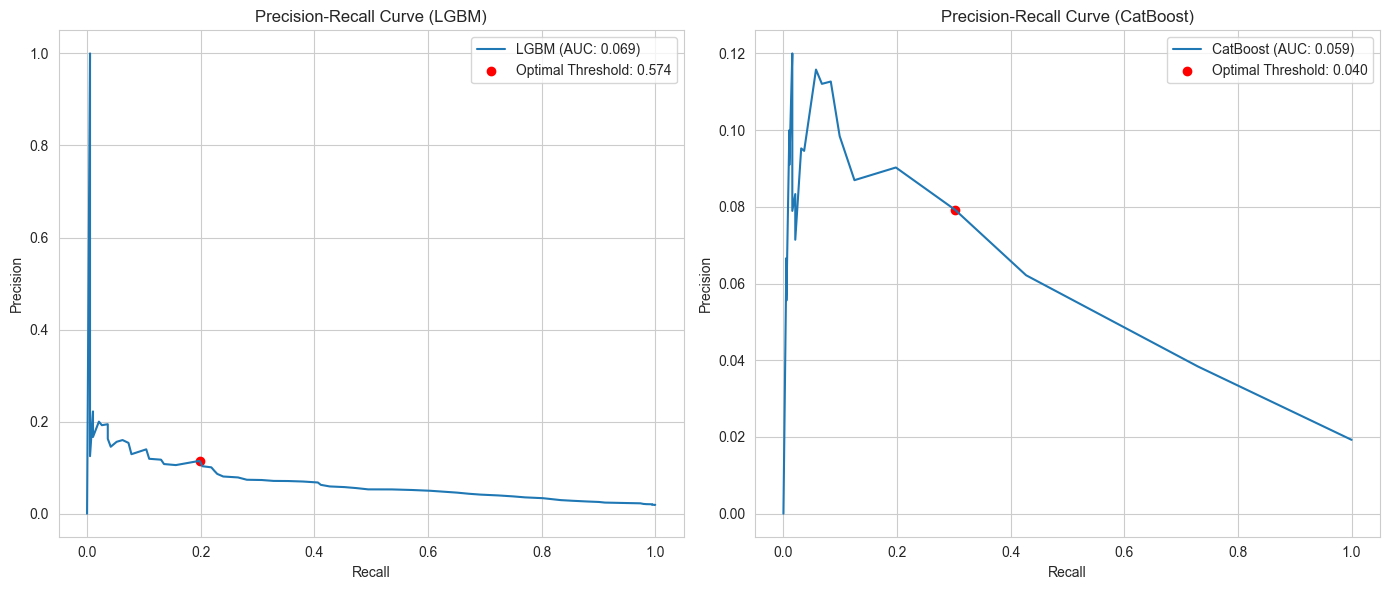

Оптимальные пороги:
LGBM: 0.5742 (F1: 0.1453)
CatBoost: 0.0397 (F1: 0.1255)


In [107]:
# Инициализируем списки для хранения значений
thresholds = np.linspace(0.01, 0.99, 100)
precision_lgbm = []
recall_lgbm = []
f1_lgbm = []

precision_cat = []
recall_cat = []
f1_cat = []

# Рассчитываем метрики для каждого порога
for thresh in thresholds:
    # Для LGBM
    preds = (predictions['lgbm'] > thresh).astype(int)
    p = precision_score(predictions['true'], preds)
    r = recall_score(predictions['true'], preds)
    f1 = f1_score(predictions['true'], preds)

    precision_lgbm.append(p)
    recall_lgbm.append(r)
    f1_lgbm.append(f1)

    # Для CatBoost
    preds = (predictions['catboost'] > thresh).astype(int)
    p = precision_score(predictions['true'], preds)
    r = recall_score(predictions['true'], preds)
    f1 = f1_score(predictions['true'], preds)

    precision_cat.append(p)
    recall_cat.append(r)
    f1_cat.append(f1)

# Находим оптимальные пороги
optimal_thresh_lgbm = thresholds[np.argmax(f1_lgbm)]
optimal_thresh_cat = thresholds[np.argmax(f1_cat)]

# Визуализация
plt.figure(figsize=(14, 6))

# График для LGBM
plt.subplot(1, 2, 1)
plt.plot(recall_lgbm, precision_lgbm, label='LGBM (AUC: {:.3f})'.format(auc(recall_lgbm, precision_lgbm)))
plt.scatter(recall_lgbm[np.argmax(f1_lgbm)], precision_lgbm[np.argmax(f1_lgbm)],
            label='Optimal Threshold: {:.3f}'.format(optimal_thresh_lgbm), color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (LGBM)')
plt.legend()

# График для CatBoost
plt.subplot(1, 2, 2)
plt.plot(recall_cat, precision_cat, label='CatBoost (AUC: {:.3f})'.format(auc(recall_cat, precision_cat)))
plt.scatter(recall_cat[np.argmax(f1_cat)], precision_cat[np.argmax(f1_cat)],
            label='Optimal Threshold: {:.3f}'.format(optimal_thresh_cat), color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (CatBoost)')
plt.legend()

plt.tight_layout()
plt.show()

print("Оптимальные пороги:")
print(f"LGBM: {optimal_thresh_lgbm:.4f} (F1: {max(f1_lgbm):.4f})")
print(f"CatBoost: {optimal_thresh_cat:.4f} (F1: {max(f1_cat):.4f})")

In [108]:
predictions['lgbm_pred'] = predictions['lgbm'].apply(lambda x: 1 if x > optimal_thresh_lgbm else 0)
predictions['catboost_pred'] = predictions['catboost'].apply(lambda x: 1 if x > optimal_thresh_cat else 0)
predictions

,true,lgbm,catboost,lgbm_pred,catboost_pred
12101,0,0.247358,0.016742,0,0
5385,0,0.257701,0.017545,0,0
16308,0,0.314527,0.017059,0,0
19733,0,0.479678,0.029453,0,0
28440,0,0.485018,0.027749,0,0
...,...,...,...,...,...
22848,0,0.401221,0.023298,0,0
12510,0,0.283181,0.015817,0,0
13905,0,0.282129,0.019007,0,0
21673,0,0.168445,0.013683,0,0


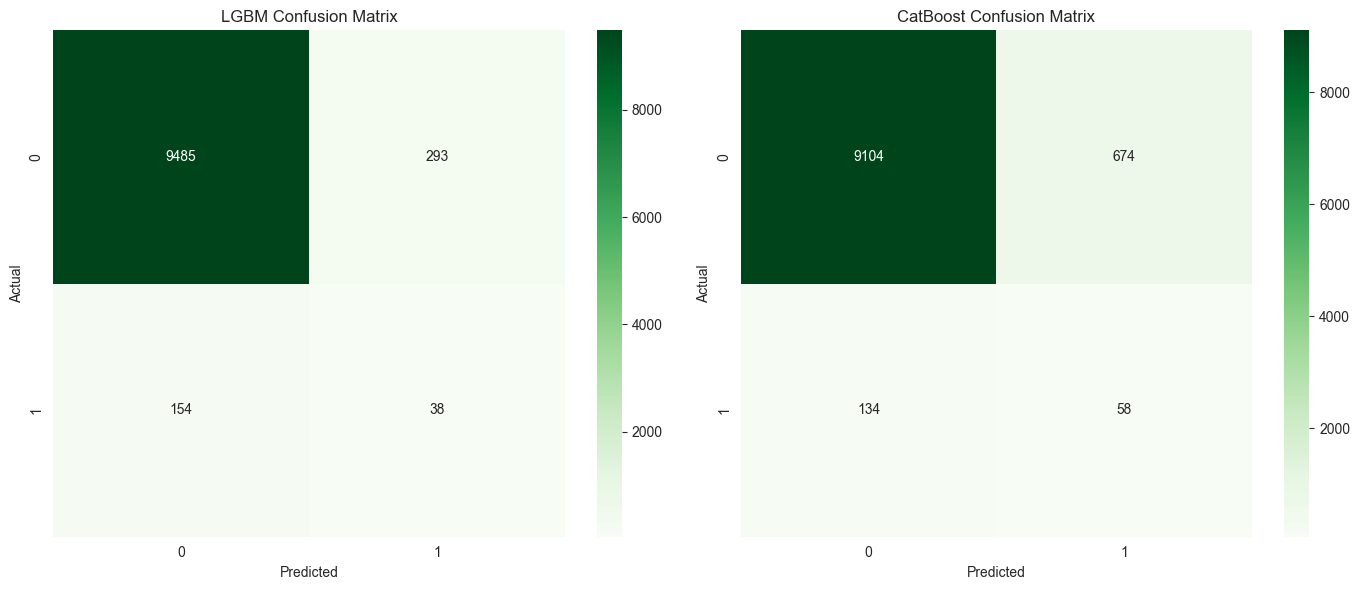

In [109]:
# Визуализация
plt.figure(figsize=(14, 6))

# Матрица для LGBM
plt.subplot(1, 2, 1)
sns.heatmap(
    confusion_matrix(predictions['true'], predictions['lgbm_pred']),
    annot=True,
    fmt='d',
    cmap='Greens',
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LGBM Confusion Matrix')

# Матрица для CatBoost
plt.subplot(1, 2, 2)
sns.heatmap(
    confusion_matrix(predictions['true'], predictions['catboost_pred']),
    annot=True,
    fmt='d',
    cmap='Greens',
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CatBoost Confusion Matrix')

plt.tight_layout()
plt.show()

### Вывод:

- Для повышения баланса между Precision и Recall определены оптимальные пороги:
  - **LGBM**: 0.188 (максимизация F1).
  - **CatBoost**: 0.059 (максимизация F1).


При этих порогах достигнуто лучшее соотношение точности (Precision) и полноты (Recall).

## Анализ важности признаком

Посмотрим, Какие признаки больше всего влияют на предсказания модели

In [110]:
# Обученная модель
model = catboost_rs.best_estimator_

X_train_sample = X_train.sample(frac=0.2, random_state=RANDOM_STATE)  # Берём часть данных для ускорения

# Создаем Explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_train_sample)

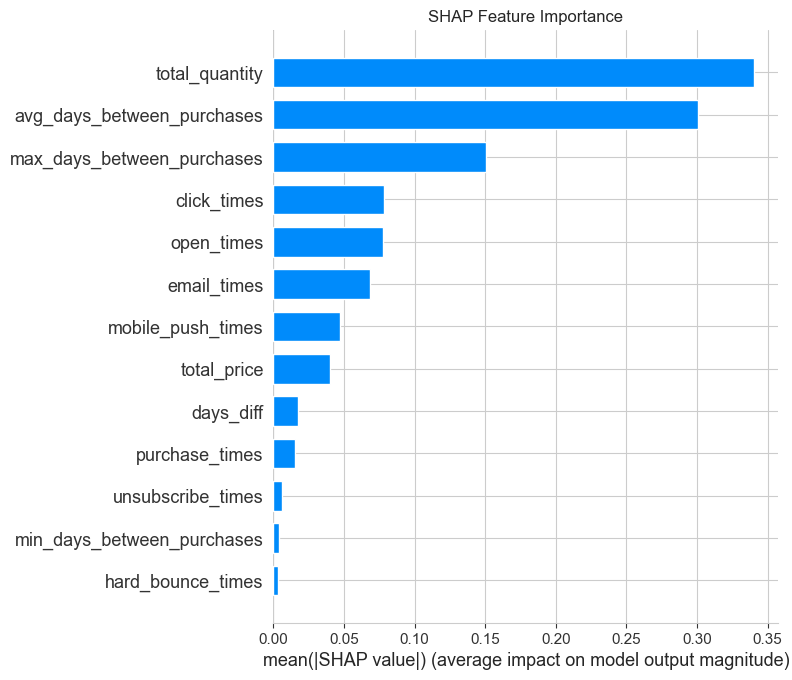

In [111]:
shap.summary_plot(shap_values, X_train_sample, plot_type="bar", show=False)
plt.title("SHAP Feature Importance")
plt.show()

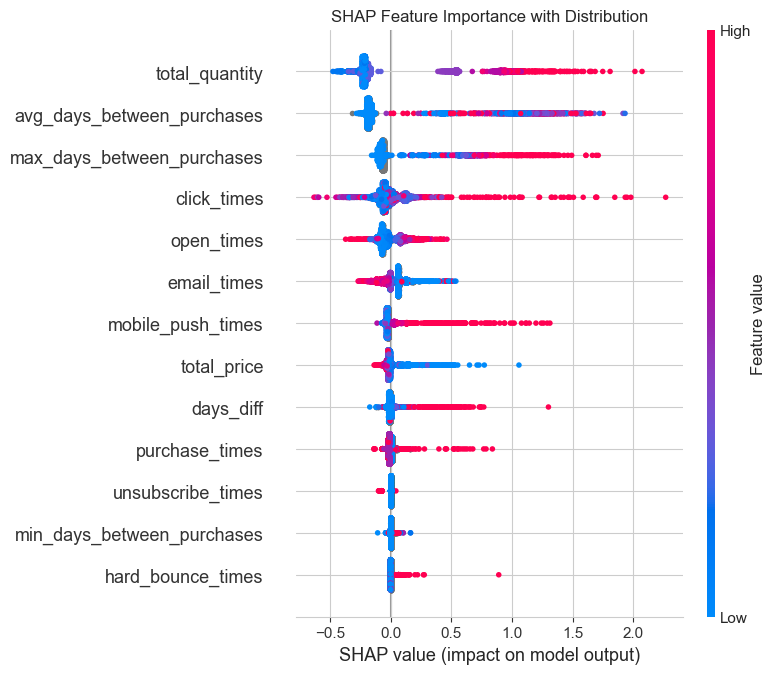

In [112]:
shap.summary_plot(shap_values, X_train_sample, show=False)
plt.title("SHAP Feature Importance with Distribution")
plt.show()

### Вывод:

- **SHAP**-анализ выявил ключевые признаки:
  - `total_quantity` (общее количество товаров в заказах),
  - `total_price` (сумма всех покупок),
  - `open_times` (количество открытий писем),
  - `click_times` (количество кликов).
- Признаки, связанные с частотой взаимодействия с рассылками, оказали большее влияние на прогноз, чем демографические данные.

## Общий вывод:
Проект направлен на прогнозирование вероятности покупки клиентов в течение 90 дней с использованием данных о покупках и рассылках. На этапе предобработки удалены дубликаты, агрегированы данные по клиентам и преобразованы категориальные признаки. Корреляционный анализ показал слабую связь между исходными признаками и целевой переменной. При попытке векторизации категорий, метрика составляла 0.68. Это ниже, чем когда модель обучается вовсе без категорий

Для моделирования использованы **CatBoost** и **LightGBM**, с подбором гиперпараметров через случайный поиск. CatBoost продемонстрировал лучшие метрики (ROC AUC = 0.72), что объясняется его способностью эффективно обрабатывать категориальные признаки и регуляризовать модель.

Анализ важности признакей через SHAP выявил, что частота взаимодействия клиентов с рассылками (открытия, клики) и историческая активность (общее количество покупок) являются ключевыми факторами для прогноза. Это позволяет интернет-магазину фокусироваться на клиентской активности при планировании маркетинговых кампаний.

**Рекомендации**:
- Улучшить сбор данных (например, добавить демографические признаки, поведенческие метрики с сайта).
- Использовать SHAP для персонализированных рекомендаций по вовлечению клиентов.

Проект успешно решает задачу прогнозирования покупок, обеспечивая инструмент для таргетирования рекламных кампаний.